In [1]:
%matplotlib inline
import grale.lenses as lenses
import grale.images as images
import grale.plotutil as plotutil
import grale.renderers as renderers
import grale.feedback as feedback
import grale.cosmology as cosmology
import grale.inversion as inversion
import grale.multiplane as multiplane
import grale.util as util
from grale.constants import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import glob
import os
import pickle
import copy
from IPython.core.display import display, HTML
import scipy.optimize as opt

plt.rcParams.update({'font.size': 11})

V = lambda x,y: np.array([x, y], dtype=np.double)

feedback.setDefaultFeedback("notebook")
plotutil.setDefaultAngularUnit(ANGLE_ARCSEC)
renderers.setDefaultLensPlaneRenderer("threads")
renderers.setDefaultMassRenderer("threads")

zs = 3

def loadSettings():
    fn = "images_a1689.txt"
    with open(fn) as f:
        l1 = f.readline().strip()
        l2 = f.readline().strip()
        
    zd = float(l1.split("=")[1])
    cosm = cosmology.Cosmology(**{ p.split("=")[0]: float(p.split("=")[1]) for p in l2[1:].strip().split() })
    
    def la(line):
        x, y, td, z = map(float, line.split())
        return { "x": x*ANGLE_ARCSEC, "y": y*ANGLE_ARCSEC, "timedelay": td, "z": z }
    
    imgList = images.readInputImagesFile(fn, True, lineAnalyzer=la)
    
    allPts = np.array([ p["position"] for i in imgList for img in i["imgdata"].getAllImagePoints() for p in img ])   
    critDens = lenses.getCriticalDensity(cosm.getAngularDiameterDistance(zd),
                                        cosm.getAngularDiameterDistance(zs),
                                        cosm.getAngularDiameterDistance(zd, zs))
    return zd, cosm, imgList, critDens


In [2]:
zd, cosm, imgList, critDens = loadSettings()
imgsAll, imgsFirst = imgList, imgList[:1]
realLensFile = "a1689_bestopt.par"
realLens, _, _ = lenses.createLensFromLenstoolFile(realLensFile)
strongSize = 180*ANGLE_ARCSEC

In [3]:
liCache = { }

In [4]:
def getCacheFileName(hsh):
    return "licache_" + hsh + ".pickle"

def getLIEntry(fileName):
    import hashlib
    data = open(fileName, "rb").read()
    s = hashlib.sha256()
    s.update(data)
    h = s.hexdigest()
    if h in liCache:
        return liCache[h]
        
    cfn = getCacheFileName(h)
    #print(cfn)
    if os.path.exists(cfn):
        liCache[h] = pickle.load(open(cfn, "rb"))
        assert(h == liCache[h]["hash"])
        return liCache[h]

    if fileName.endswith(".par"):
        lens, _, _ = lenses.createLensFromLenstoolFile(fileName)
    else:
        lens = lenses.GravitationalLens.load(fileName)
    liNarrow = plotutil.LensInfo(lens, size=strongSize, zd=zd, cosmology=cosm) 
    d = { "narrow": liNarrow, "filename": fileName, "hash": h, "lens": lens }
    liCache[h] = d
    return d
    
def saveCaches():
    for n in liCache:
        print(n, liCache[n]["filename"])
        cfn = getCacheFileName(n)
        pickle.dump(liCache[n], open(cfn,"wb"))

In [5]:
def saveFig(fn):
    plt.savefig(fn, bbox_inches="tight")

In [6]:
def centerDist(pos):
    xy = V(*pos)
    center = V(0,0)    
    diff = xy-center
    return np.sum(diff**2)**0.5

def createDensAtImagePosPlot(fn, plotLegend, top=None):
    li = getLIEntry(fn)
    plotutil.plotDensitiesAtImagePositions(li["lens"], imgsAll, horCoordFunction=centerDist, densityUnit=critDens,
                                           label="Reconstructed density")
    numAvg = len(li["lens"].getLensParameters())
    print(f"Looks like average of {numAvg} solutions")

    plotutil.plotDensitiesAtImagePositions(realLens, imgsAll, horCoordFunction=centerDist, densityUnit=critDens, 
                                           marker="x", label="True density")
    plt.gca().set_xlabel("Distance from center (arcsec)")
    plt.gca().set_ylabel("$\kappa$")
    plt.gca().set_ylim(bottom=0, top=top)
    
    plt.gca().set_aspect("auto")
    if plotLegend:
        plt.legend()

def getYesNo(s):
    if s == "yes":
        return True
    if s == "no":
        return False
    raise Exception(f"Expecting yes or no but got '{s}'")
    
def getOptionsFromFilename(fn, prefix="avg-", suffix=".lensdata"):
    if not fn.startswith(prefix):
        raise Exception(f"Filename '{fn}' does not start with prefix '{prefix}'")
    if not fn.endswith(suffix):
        raise Exception(f"Filename '{fn}' does not end with suffix '{suffix}'")
    
    opts = { }
    parts = fn[len(prefix):-len(suffix)].split("-")
    for p in parts:
        if p.startswith("of_"):
            opts["onlyfirst"] = getYesNo(p[3:])
        elif p.startswith("td_"):
            opts["tdtype"] = p[3:]
        elif p.startswith("rms_"):
            opts["rms"] = getYesNo(p[4:])
        elif p.startswith("sys_"):
            opts["sysname"] = p[5:]
        else:
            raise Exception(f"Unknown prefix in part '{p}'")
    return opts

def getIWS(fn, noOpts = False):
    iws = inversion.InversionWorkSpace(zd, 60*ANGLE_ARCSEC, cosmology=cosm)
    for i in imgList:
        iws.addImageDataToList(i["imgdata"], i["z"], "pointimages")
    return iws

def calculateFitness(fn):   
    li = getLIEntry(fn)
    iws = getIWS(fn)
    return iws.calculateFitness(li["lens"])

def drawFilledCircles(centers, size):
    for ctr in centers:
        c = plt.Circle(ctr, radius=size/2 , color="#bbbbbb")
        plt.gca().add_artist(c)

In [7]:
def plotMassMap(fn):
    li = getLIEntry(fn)
    plotutil.plotDensityContours(li["narrow"], densityUnit=critDens, levels=np.linspace(0,4,21), colors="gray")
    plotutil.plotDensityContours(li["narrow"], densityUnit=critDens, levels=[1], colors=['black'], linewidths=[3])
    plt.gca().set_xlabel("X (arcsec)")
    plt.gca().set_ylabel("Y (arcsec)")

In [8]:
def plotImagePoints(imgs, **kwargs):

    for img in [ i["imgdata"] for i in imgs ]:
        n = img.getNumberOfImages()
        points = { }
        for i in range(n):
            pt = V(0,0)
            for pts in img.getImagePoints(i):
                pt += pts["position"]
            pt /= img.getNumberOfImagePoints(i)
            points[i] = pt

        points = [ points[k] for k in points]
        if points:
            points = np.array(points)
            plt.plot(points[:,0]/ANGLE_ARCSEC, points[:,1]/ANGLE_ARCSEC, **kwargs)
            kwargs["label"] = None

def plotImagePlane(fn, onlyFirst = False):
    li = getLIEntry(fn)
    liReal = getLIEntry(realLensFile)
    liReal["narrow"].setSourceRedshift(zs)
    li["narrow"].setSourceRedshift(zs)

    plotutil.plotImagePlane(liReal["narrow"], bgRgb=(0,0,0,0), critColor="black", 
                            critKw={ "linestyle": "-", "linewidth": 1 }, plotCaustics=False)
    plotutil.plotImagePlane(li["narrow"], bgRgb=(0,0,0,0), critColor="black", 
                            critKw={ "linestyle": "-", "linewidth": 2 }, plotCaustics=False)
    
    plotImagePoints(imgsAll, marker='.', markersize=11, color="black", linestyle="")
    
    if onlyFirst:
        plotImagePoints(imgsFirst, marker="s", markersize=10, linestyle="", color="black", markerfacecolor="none")
        
    plt.gca().set_xlabel("X (arcsec)")
    plt.gca().set_ylabel("Y (arcsec)")
    #plt.legend()

def createBPPlot(fn, plotRef = True):
    li = getLIEntry(fn)
    iws = getIWS(fn, noOpts=True)
    bpImgs = iws.backProject(li["lens"])
    
    #plotutil.plotImagesData(bpImgs)
    if plotRef:
        allPts = np.array([ p["position"] for i in bpImgs for img in i.getAllImagePoints() for p in img ])
    else:
        allPts = np.array([ p["position"] for i in bpImgs for img in i.getAllImagePoints()[:1] for p in img ])
        
    plt.plot(allPts[:,0]/ANGLE_ARCSEC, allPts[:,1]/ANGLE_ARCSEC, '.', markersize=11, color="black")
    
    plt.gca().set_aspect("equal", adjustable="datalim")
    plt.gca().set_xlabel("X (arcsec)")
    plt.gca().set_ylabel("Y (arcsec)")
    
    if plotRef:
        
        srcPos = getTrueSourcePos()
        centers = np.array([getCenter(getPoints(img)) for img in bpImgs])/ANGLE_ARCSEC
        curCenter = getCenter(centers)
        
        plotTrueSources(srcPos, curCenter, "True positions (offset)")
        lambd = estimateLambdaFromBP(fn)
        plt.plot([],[],".",color="white",label=r"$\lambda_{{\rm est}}$ = {:.02f}".format(lambd))

        plt.legend()
    
def plotSourceCenters(fn, centerOn=None, plot=True, **kwargs):
    li = getLIEntry(fn)
    iws = getIWS(fn, noOpts=True)
    bpImgs = iws.backProject(li["lens"])
    centers = np.array([getCenter(getPoints(img)) for img in bpImgs])/ANGLE_ARCSEC
    curCenter = getCenter(centers)
    
    if centerOn is None:
        if plot: plt.plot(centers[:,0], centers[:,1], 'x', **kwargs)
    else:
        curCenter = getCenter(centers)
        off = np.array(centerOn) - curCenter
        if plot: plt.plot(centers[:,0]+off[0], centers[:,1]+off[1], 'x', **kwargs)
        
    return centers, curCenter
    
def getPoints(imgDat):
    pts = np.array([ p["position"] for img in imgDat.getAllImagePoints() for p in img  ])
    return pts

def getCenter(pts):
    minx, maxx = np.min(pts[:,0]), np.max(pts[:,0])
    miny, maxy = np.min(pts[:,1]), np.max(pts[:,1])
    return V((minx+maxx)/2, (miny+maxy)/2)

In [9]:
def getSize(pts):
    minx, maxx = np.min(pts[:,0]), np.max(pts[:,0])
    miny, maxy = np.min(pts[:,1]), np.max(pts[:,1])
    return V((-minx+maxx), (-miny+maxy))

def getDiag(dx, dy):
    return (dx**2+dy**2)**0.5

def estimateLambdaFromBP(fn):
    li = getLIEntry(fn)
    iws = getIWS(fn, noOpts=True)
    bpImgs = iws.backProject(li["lens"])
    
    allPts = np.array([ p["position"] for i in bpImgs for img in i.getAllImagePoints() for p in img ])/ANGLE_ARCSEC
    srcPos = getTrueSourcePos()

    reconstr = getDiag(*getSize(allPts))
    real = getDiag(*getSize(srcPos))
    return reconstr/real

In [10]:
def getTrueSourcePos():
    li = getLIEntry(realLensFile)
    iws = getIWS(realLensFile, noOpts=True)
    bpImgs = iws.backProject(li["lens"])
    centers = np.array([getCenter(getPoints(img)) for img in bpImgs])/ANGLE_ARCSEC
    return centers

def plotTrueSources(pos, centerOn, label):
    curCenter = getCenter(pos)
    off = np.array(centerOn) - curCenter
    
    pos = pos+off
    
    plt.plot(pos[:,0], pos[:,1], 'o', color='#00000000')
    drawFilledCircles(pos, 1)
    xlim, ylim = plt.xlim(), plt.ylim()
    plt.plot([-1000], [-1000], 'o', markersize=8, color='#bbbbbb', label=label)
    plt.gca().set_xlim(xlim)
    plt.gca().set_ylim(ylim)
    #plt.legend()

In [11]:
def plotResidualMassMap(fn):
    li = getLIEntry(fn)["narrow"]
    realLi = getLIEntry(realLensFile)["narrow"]
    
    area = li.getArea()
    dens = li.getDensityPoints()
    densReal = realLi.getDensityPoints()
    
    frac = (dens-densReal)/densReal
    di = plotutil.DensInfo(frac, **area)
    
    def addBar(a):
        plt.colorbar(a, fraction=0.0465, pad=0.02)
    
    plotutil.plotDensity(di, cmap="gray_r", vmin=0, vmax=1, axImgCallback=addBar)
    plotutil.plotDensityContours(di, levels=np.arange(0,1,0.1),colors=["black"])
    plt.gca().set_xlabel("X (arcsec)")
    plt.gca().set_ylabel("Y (arcsec)")
    
def createAllPlots(fn):
    opts = getOptionsFromFilename(fn)
    plt.figure(figsize=(13,4))
    plt.subplot(1,3,1)
    plotMassMap(fn)
    plt.subplot(1,3,2)
    plotImagePlane(fn, opts["onlyfirst"])
    #plt.gca().set_ylabel(None)
    plt.subplot(1,3,3)
    createBPPlot(fn)
    #plt.gca().set_ylabel("")
    plt.tight_layout()

Text(value='')

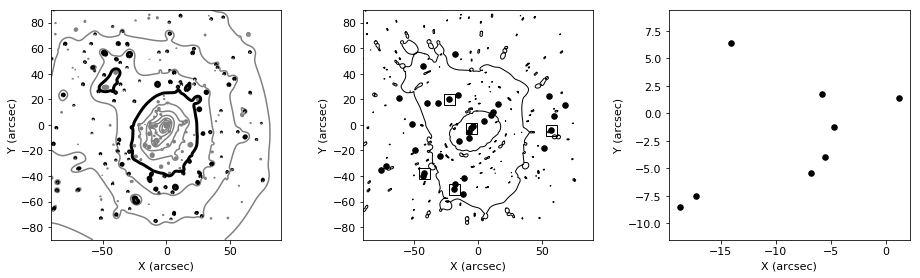

In [12]:
def createRealLensPlots():
    fn = realLensFile
    li = getLIEntry(fn)
    li["narrow"].setSourceRedshift(zs)
    
    plt.figure(figsize=(13,4))
    plt.subplot(1,3,1)
    plotMassMap(fn)
    
    plt.subplot(1,3,2)
    plotutil.plotImagePlane(li["narrow"], plotCaustics=False, bgRgb=(0,0,0,0), critColor="black", critKw={"linestyle": "-", "linewidth": 1})
    for i in imgsAll:
        pts = getPoints(i["imgdata"])/ANGLE_ARCSEC
        plt.plot(pts[:,0], pts[:,1], '.', markersize=11, color="black")
        
    for i in imgsAll[:1]:
        pts = getPoints(i["imgdata"])/ANGLE_ARCSEC
        plt.plot(pts[:,0], pts[:,1], 's', markersize=11, markeredgecolor="black", markerfacecolor='none')
        
    plt.gca().set_xlabel("X (arcsec)")
    plt.gca().set_ylabel("Y (arcsec)")

    plt.subplot(1,3,3)
    createBPPlot(realLensFile, plotRef=False)
    plt.tight_layout()

plt.rcParams.update({'font.size': 11})
createRealLensPlots()

Text(value='')

Text(value='')

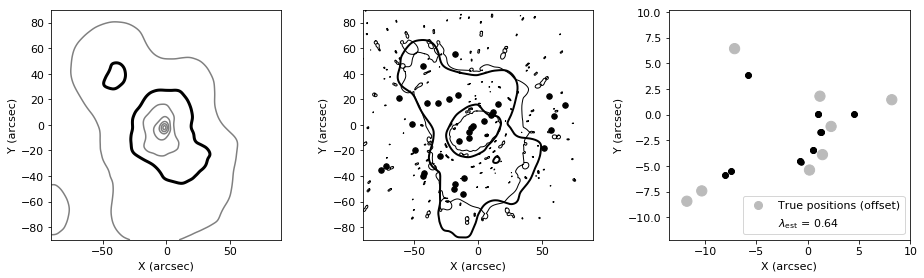

In [13]:
plt.rcParams.update({'font.size': 11})
createAllPlots("avg-sys_a1689-of_no-td_Paper2009-rms_no.lensdata")

Text(value='')

Text(value='')

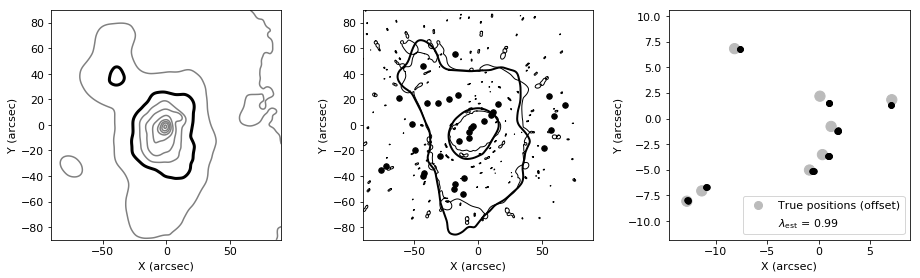

In [14]:
createAllPlots("avg-sys_a1689-of_no-td_ExperimentalII-rms_no.lensdata")

In [15]:
def createBothDensAtImagePosPlot(fn, ax, top=None, left=True, plotLegend=True):
    li = getLIEntry(fn)
    
    plotutil.plotDensitiesAtImagePositions(li["lens"], imgsAll, horCoordFunction=centerDist, densityUnit=critDens,
                                           label="Reconstructed density", axes=ax)
    
    numAvg = len(li["lens"].getLensParameters())
    print(f"Looks like average of {numAvg} solutions")

    plotutil.plotDensitiesAtImagePositions(realLens, imgsAll, horCoordFunction=centerDist, densityUnit=critDens, 
                                           marker="x", label="True density", axes=ax)
    ax.set_xlabel("Distance from center (arcsec)")
    ax.set_ylabel("$\kappa$")
    if not left:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        
    ax.set_ylim(bottom=0, top=top)
   
    ax.set_aspect("auto")
    if plotLegend:
        plt.legend()

In [16]:
def createRelativeDensAtImagePosPlot(fn, ax, relTopBottom=None, left=True):
    li = getLIEntry(fn)
    
    savedRealDens = { }
    def saveDens(l, pos, imgIdx):
        x = l.getSurfaceMassDensity(pos)
        savedRealDens[tuple(pos)] = x
        return x
    
    plotutil.plotDensitiesAtImagePositions(realLens, imgsAll, horCoordFunction=centerDist, densityUnit=critDens, 
                                           marker="x", label="True density", axes=False, densFunction=saveDens)
    
    def fracDens(l, pos, imgIdx):
        densReal = savedRealDens[tuple(pos)]
        x = l.getSurfaceMassDensity(pos)
        #return (x-densReal)/densReal
        return x/densReal
    
    # Note that densityUnit has to be 1, since we don't have any unit anymore
    plotutil.plotDensitiesAtImagePositions(li["lens"], imgsAll, horCoordFunction=centerDist, densityUnit=1,
                                           label="Reconstructed density", axes=ax, densFunction=fracDens)

    #ax.set_ylabel(r"$(\kappa - \kappa_{\rm R})/\kappa_{\rm R}$")
    ax.set_ylabel(r"$\kappa/\kappa_{\rm R}$")
    
    if not left:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")

    ax.plot([0,100],[1,1],'--',color="gray")
    
    if relTopBottom is not None:
        ax.set_ylim(*relTopBottom)

In [17]:
def addBar(a):
    plt.colorbar(a, fraction=0.046, pad=0.04)

def plotRelDens2D(fn, ax=None):
    ax = plt.gca() if ax is None else ax
    li = getLIEntry(fn)["narrow"]
    liReal = getLIEntry(realLensFile)["narrow"]
    
    dens, densReal = li.getDensityPoints(), liReal.getDensityPoints()
    frac = (dens-densReal)/densReal
    area = li.getArea()
    
    di = plotutil.DensInfo(frac, **area)
    plotutil.plotDensity(di,axImgCallback=addBar, cmap="gray_r")

def plotLogRelDens2D(fn, ax=None):
    ax = plt.gca() if ax is None else ax
    li = getLIEntry(fn)["narrow"]
    liReal = getLIEntry(realLensFile)["narrow"]
    
    dens, densReal = li.getDensityPoints(), liReal.getDensityPoints()
    frac = abs(np.log10(dens/densReal))
    area = li.getArea()
    
    di = plotutil.DensInfo(frac, **area)
    plotutil.plotDensity(di,axImgCallback=addBar, cmap="gray_r")
    plotutil.plotDensityContours(di, levels=[np.log10(0.9),np.log10(1.1)], colors="black")
    
def plotFracRelDens2D(fn, ax=None):
    ax = plt.gca() if ax is None else ax
    li = getLIEntry(fn)["narrow"]
    liReal = getLIEntry(realLensFile)["narrow"]
    
    dens, densReal = li.getDensityPoints(), liReal.getDensityPoints()
    frac = dens/densReal
    area = li.getArea()
    
    di = plotutil.DensInfo(frac, **area)
    clevels = [0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
    norm= colors.BoundaryNorm(clevels, 256)
    plotutil.plotDensity(di,axImgCallback=addBar, cmap="bwr_r", norm=norm)
    plotutil.plotDensityContours(di, levels=[0.9, 1.1], colors="black", linewidths=[0.75], linestyles=["-","-"])


In [18]:
def getMagFromLensPlane(lp, dfrac):
    r = lp.getAlphaVectorDerivatives()
    axx, ayy, axy = r["alpha_xx"]*dfrac, r["alpha_yy"]*dfrac, r["alpha_xy"]*dfrac
    invMag = (1.0-axx)*(1.0-ayy)-axy*axy
    return 1.0/invMag

def plotFracRelMag2D(fn, ax=None):
    ax = plt.gca() if ax is None else ax
    li = getLIEntry(fn)["narrow"]
    liReal = getLIEntry(realLensFile)["narrow"]
    
    zs = 9
    Ds, Dds = cosm.getAngularDiameterDistance(zs), cosm.getAngularDiameterDistance(zd,zs)
    
    mu = getMagFromLensPlane(li.getLensPlane(), Dds/Ds)
    muReal = getMagFromLensPlane(liReal.getLensPlane(), Dds/Ds)
    
    frac = np.log10(abs(mu/muReal))
    #frac = abs(mu/muReal)
    area = li.getArea()
    
    di = plotutil.DensInfo(frac, **area)
    #clevels = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]
    clevels = [-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9]
    #clevels = [-1,-0.6,-0.2,0.2,0.6,1]
    norm= colors.BoundaryNorm(clevels, 256)
    plotutil.plotDensity(di,axImgCallback=addBar, cmap="bwr_r",vmin=-1,vmax=1, norm=norm)
    #plotutil.plotDensityContours(di, levels=[-0.2, 0.2], colors="black", linewidths=[0.75], linestyles=["-","-"])

    ax.set_title("$\log_{10}|\mu/\mu_R|$")

Looks like average of 40 solutions


Text(value='')

Text(value='')

Looks like average of 40 solutions


Text(value='')

Text(value='')

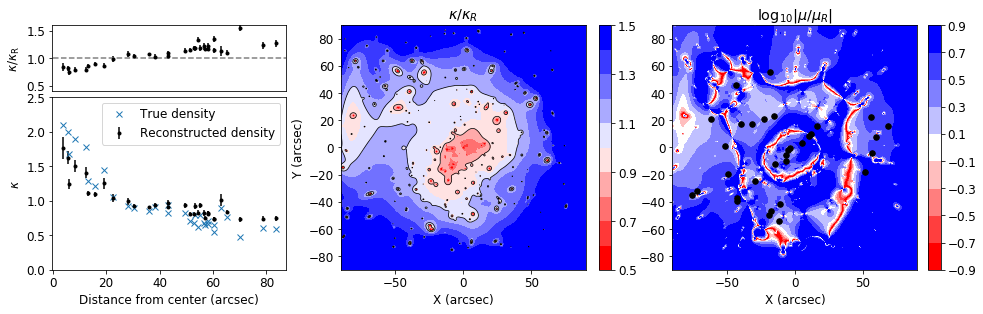

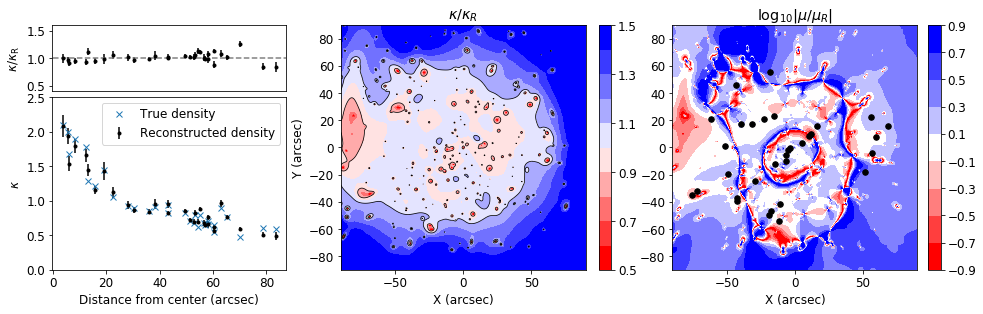

In [19]:
def plotRelativeQuantities2(fn, plotLegend=True):

    plt.figure(figsize=(13,4))
    fig = plt.gcf()    

    #plt.subplot(1,3,1)

    x0 = 0.05
    xw = 0.25
    top = 2.5
    left = True
    relTopBottom = [0.4,1.6]

    ax = fig.add_axes([ x0, 0.1, xw, 0.6])
    createBothDensAtImagePosPlot(fn, ax, top, left, plotLegend)
    xlimits = ax.get_xlim()

    ax = fig.add_axes([ x0, 0.72, xw, 0.23], xticklabels=[], xticks=[])
    createRelativeDensAtImagePosPlot(fn, ax, relTopBottom, left)
    ax.set_xlim(*xlimits)

    ax = fig.add_axes([ 0.3, 0.1, 0.35, 0.85])
    plotFracRelDens2D(fn)
    ax.set_title("$\kappa/\kappa_R$")
    ax.set_xlabel("X (arcsec)")
    ax.set_ylabel("Y (arcsec)")

    #plt.subplot(1,3,3)
    x0 = 0.7
    xw = 0.3
    top = 100
    left = False
    relTopBottom = None

    ax = fig.add_axes([ x0, 0.1, xw, 0.85])
    plotFracRelMag2D(fn,ax)
    plotImagePoints(imgsAll, marker='.', markersize=11, color="black", linestyle="")
    ax.set_xlabel("X (arcsec)")
    #ax.set_ylabel("Y (arcsec)")

plt.rcParams.update({'font.size': 12})
plotRelativeQuantities2("avg-sys_a1689-of_no-td_Paper2009-rms_no.lensdata")
plotRelativeQuantities2("avg-sys_a1689-of_no-td_ExperimentalII-rms_no.lensdata")

In [20]:
def getIndividualSolutions(lens):
    sublenses = [ ]
    if type(lens) == lenses.CompositeLens:
        params = lens.getLensParameters()
        expectedFactor = 1.0/len(params)
        isAverage = True
        for p in params:
            if p["x"] != 0 or p["y"] != 0 or p["angle"] != 0 or abs(p["factor"]-expectedFactor) > 1e-7:
                isAverage = False
                break
                
        if isAverage:
            print(f"Average lens ({len(params)})")
            sublenses = [ p["lens"] for p in params ]
        else:
            print("Composite lens, but not an average")
            sublenses = [ lens ]
    else:
        print("Not a composite lens, not an average")
        sublenses = [lens]
        
    return sublenses

def getInputTimeDelays(imgDat):
    pts = [ ]
    for i in range(imgDat.getNumberOfTimeDelays()):
        imgNr, ptNr, td = imgDat.getTimeDelay(i)
        pos = imgDat.getImagePointPosition(imgNr, ptNr)
        pts.append({"pos": pos, "td_obs": td})
    return pts

def checkSamePoint(p1, p2):
    diff = np.sum((p1-p2)**2)**0.5
    if diff != 0:
        raise Exception(f"Points for index {pIdx} don't match")

def getSingleTimeDelayPredictions(lens, pts, z, multiLensPlane):
    #print("Pts:")
    #pprint.pprint(pts)
    imgDat = images.ImagesData(len(pts))
    for pIdx in range(len(pts)):
        imgDat.addPoint(pIdx, pts[pIdx]["pos"])
      
    if False: # Checked that this leads tot the same results
        if multiLensPlane is None:
            numXY=127
            multiLensPlane = multiplane.MultiLensPlane([(lens,zd)], 
                                                   -V(strongSize,strongSize)/2, V(strongSize,strongSize)/2, 
                                                   numXY, numXY, cosmology=cosm, feedbackObject="default")
        
        pred = util.calculateImagePredictions([{"imgdata": imgDat, "z": z }], multiLensPlane)[0]
    else:
        pred = util.calculateImagePredictions([{"imgdata": imgDat, "z": z }], lens, cosmology=cosm)[0]
    
    assert(len(pred[0]["beta_est"]) == 1) # Only one average should be present
    beta_pred = pred[0]["beta_est"][0]

    # Check that they are in the same order and all have same beta
    for pIdx in range(len(pts)):
        checkSamePoint(pts[pIdx]["pos"], pred[pIdx]["theta_obs"])
        checkSamePoint(beta_pred, pred[pIdx]["beta_est"][0])

    Dds, Ds = cosm.getAngularDiameterDistance(zd,z), cosm.getAngularDiameterDistance(z)
    tds = lens.getTimeDelay(zd, Ds, Dds, np.array([p["theta_pred"] for p in pred]), beta_pred) / (60*60*24) # Convert to days
    tds -= min(tds)
    
    # We've checked that the points are in the same order, so add the calculated time delays
    for pIdx in range(len(pts)):
        pts[pIdx]["td_pred"]= float(tds[pIdx])

    return pts, multiLensPlane

def getAllTimeDelayPredictions(fn, imgList):
    #pprint.pprint(imgList)
    
    lens = lenses.GravitationalLens.load(fn)
    subLenses = getIndividualSolutions(lens)
    
    solInfo = { }
    
    def mergeInSolInfo(srcNum, tdInfo):
        if not srcNum in solInfo:
            tdCopy = copy.deepcopy(tdInfo)
            for pIdx in range(len(tdCopy)):
                tdCopy[pIdx]["td_pred"] = [ ]
            solInfo[srcNum] = tdCopy
                
        td = solInfo[srcNum]
        assert(len(td) == len(tdInfo))
        for pIdx in range(len(td)):
            checkSamePoint(td[pIdx]["pos"], tdInfo[pIdx]["pos"])
            td[pIdx]["td_pred"].append(tdInfo[pIdx]["td_pred"])
    
    for sl in subLenses:
        #print("Processing sublens", sl)
        mPlane = None
        for i in range(len(imgList)):
            #print("Processing img", i)
            pts = getInputTimeDelays(imgList[i]["imgdata"])
            tdInfo, mPlane = getSingleTimeDelayPredictions(sl, pts, imgList[i]["z"], mPlane)
            mergeInSolInfo(i, tdInfo)
            
    return solInfo

In [21]:
def processPredictions(tdPreds, startPrefixFmt):

    factor = 365
    for src in tdPreds[0][0]:
        
        tdTmp = tdPreds[0][0][src]
        #print("Source", src)
        numPairs = (len(tdTmp)*(len(tdTmp)-1))//2
        W = 6
        plt.figure(figsize=(W,numPairs*W/5))
        
        pltIdx = 0
        for i in range(len(tdTmp)-1):

            for j in range(i+1, len(tdTmp)):

                pltIdx += 1
                plt.subplot(numPairs,1, pltIdx)
                
                prefix = startPrefixFmt.format(**{"src": src+1}) if pltIdx == 1 else ""
                plt.gca().set_title(prefix + f"{i+1} ⟶ {j+1}")

                colors = [ "black", "blue", "red", "green", "purple"]
                style = [ ":", "-", "-.", "--"]
                yoffsets = [0, 0.5, -0.5, 1, -1]
                
                for setIdx in range(len(tdPreds)):

                    yo = yoffsets[setIdx]
                    
                    td = tdPreds[setIdx][0][src]
                    label = tdPreds[setIdx][1]
                    tdi_obs = td[i]["td_obs"]/factor
                    tdi_pred = np.array(td[i]["td_pred"])/factor


                    tdj_obs = td[j]["td_obs"]/factor
                    tdj_pred = np.array(td[j]["td_pred"])/factor

                    td_ij_obs = -(tdi_obs-tdj_obs)
                    td_ij_pred = -(tdi_pred-tdj_pred)
                    td_ij_pred_avg, td_ij_pred_std = np.average(td_ij_pred), np.std(td_ij_pred)

                    #print(f" obs  {i}->{j}: {td_ij_obs} y")
                    #print(f" pred {i}->{j}: {td_ij_pred_avg:.3f} +/- {td_ij_pred_std:.3f} y")
                    #print("")

                    if setIdx == 0:
                        plt.plot([td_ij_obs],[0], 'd', color="black", markerfacecolor="#00000000", markeredgecolor="black", markersize=15)
                        
                    plt.plot([td_ij_pred_avg-td_ij_pred_std,td_ij_pred_avg+td_ij_pred_std,None,
                              td_ij_pred_avg-td_ij_pred_std,td_ij_pred_avg-td_ij_pred_std,None,
                              td_ij_pred_avg+td_ij_pred_std,td_ij_pred_avg+td_ij_pred_std],
                             [0+yo, 0+yo,None,
                              -1+yo, 1+yo,None,
                              -1+yo, 1+yo], style[setIdx], color=colors[setIdx], label=label)
                    plt.plot([td_ij_pred_avg], [0+yo], '.', color=colors[setIdx])

                    plt.gca().set_ylim([-2,2])
                    plt.gca().set_yticklabels([])
                    plt.gca().set_yticks([])
                    
                    #if pltIdx == 1: plt.gca().legend()
                
        plt.tight_layout()

Average lens (40)


/home/jori/anaconda3-201812/envs/grale2env201812/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/home/jori/anaconda3-201812/envs/grale2env201812/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Average lens (40)


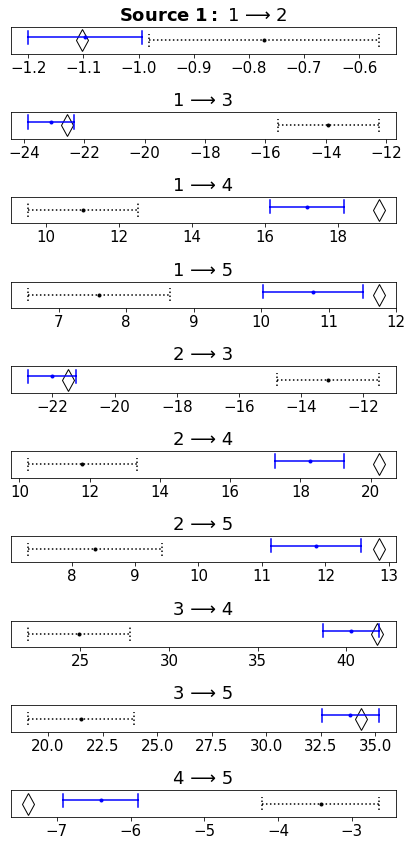

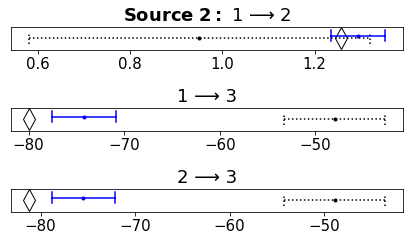

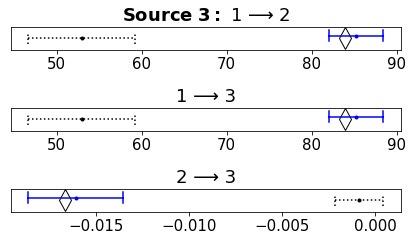

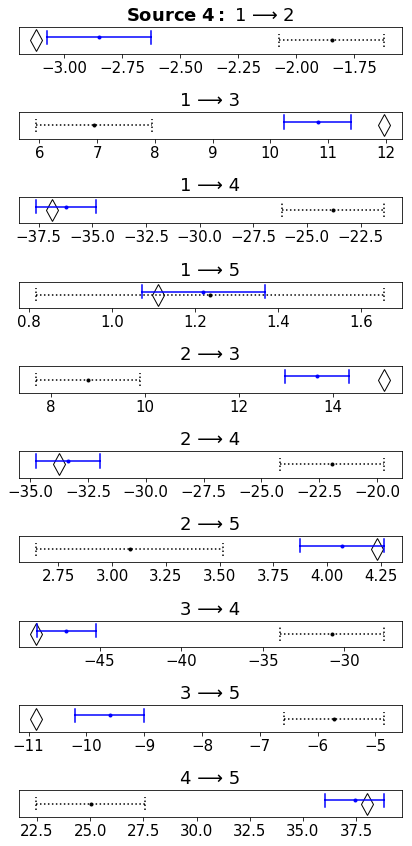

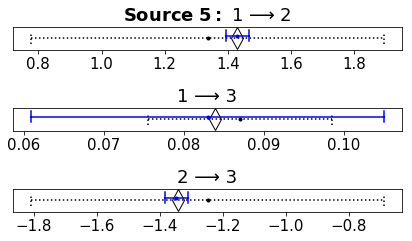

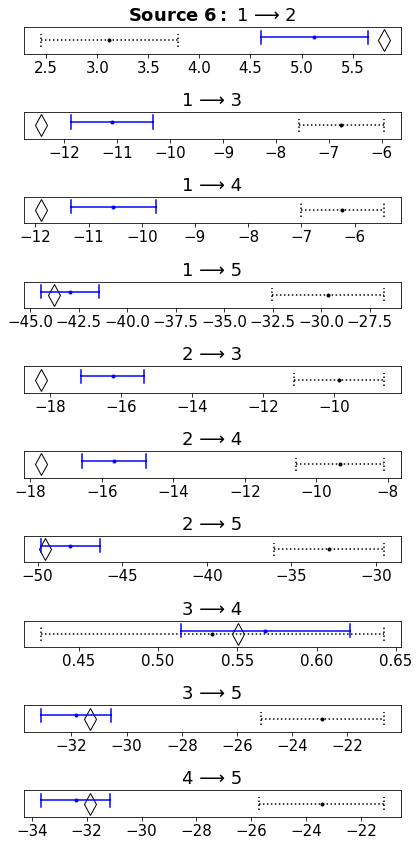

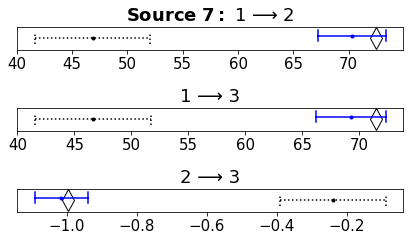

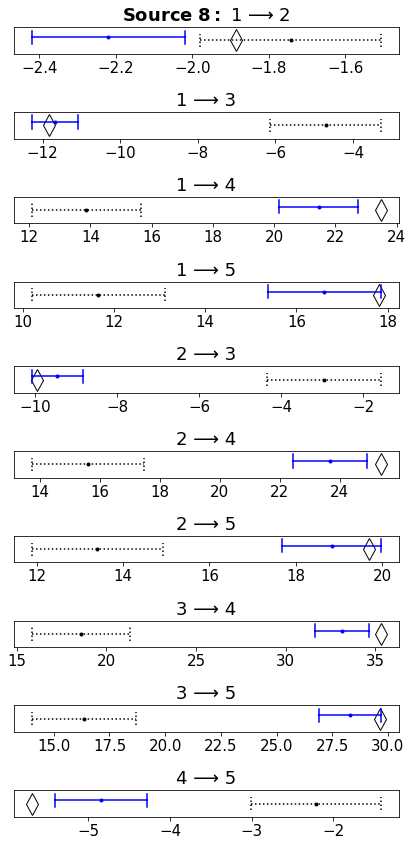

In [22]:
plt.rcParams.update({'font.size': 15})
tdPred_All_2009_gp = getAllTimeDelayPredictions("avg-sys_a1689-of_no-td_Paper2009-rms_no.lensdata", imgList)
tdPred_All_ExpII_gp = getAllTimeDelayPredictions("avg-sys_a1689-of_no-td_ExperimentalII-rms_no.lensdata", imgList)

processPredictions([(tdPred_All_2009_gp, "2009"), (tdPred_All_ExpII_gp, "NoSrc")], "$\\bf{{Source\;{src}:}}$ ")

In [25]:
def processRelativePredictions(tdPreds):

    for src in tdPreds:
        td = tdPreds[src]

        avgs, stds = [], []
        for i in range(len(td)-1):
            for j in range(i+1, len(td)):

                    tdi_obs = td[i]["td_obs"]
                    tdi_pred = np.array(td[i]["td_pred"])

                    tdj_obs = td[j]["td_obs"]
                    tdj_pred = np.array(td[j]["td_pred"])

                    td_ij_obs = -(tdi_obs-tdj_obs)
                    td_ij_pred = -(tdi_pred-tdj_pred)
                    td_ij_pred_rel_avg, td_ij_pred_rel_std = np.average(td_ij_pred/td_ij_obs), np.std(td_ij_pred/td_ij_obs)
                    
                    avgs.append(td_ij_pred_rel_avg)
                    stds.append(td_ij_pred_rel_std)
                    
        x = [ (src+1+i/20) for i in range(len(avgs))]
        plt.errorbar(x, avgs, stds, fmt='.', color="black")
        plt.plot([0,9],[1,1],'--',color="gray")
        plt.gca().set_xlim(0,9)
        plt.gca().set_xticks([1,2,3,4,5,6,7,8])
        plt.gca().set_xlabel("Source number")
        plt.gca().set_ylabel("Time delay fraction")
        plt.gca().set_ylim(0,1.4)

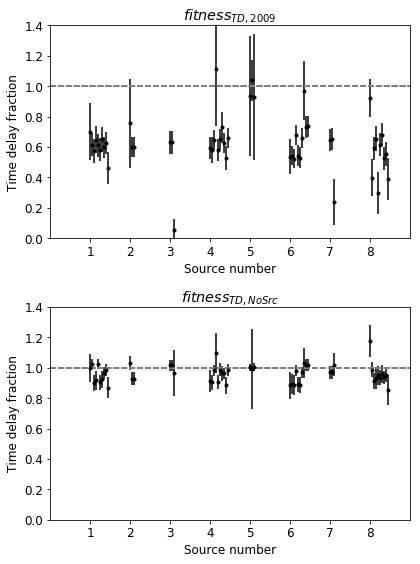

In [26]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,8))
plt.subplot(2,1,1)
processRelativePredictions(tdPred_All_2009_gp)
plt.gca().set_title("$fitness_{TD,2009}$")
plt.subplot(2,1,2)
processRelativePredictions(tdPred_All_ExpII_gp)
plt.gca().set_title("$fitness_{TD,NoSrc}$")
plt.tight_layout()